# 01__tSNE

in this notebook, i plot the 11 genomic features aggregated for lncRNAs and mRNAs in 2D using tSNE, and then perform k-means clustering.

figures in this notebook:
- Fig 6B-D: tSNE with various things highlighted
- Fig S7: tSNE colored by feature

tables in this notebook:
- Table S7: result of clustering analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import sys
import time

from matplotlib.patches import Rectangle

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from statsmodels.sandbox.stats import multicomp

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# import utils
sys.path.append("../../../utils")
from plotting_utils import *
from classify_utils import *

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2019)

## functions

In [4]:
def min_biotype(row):
    if row.cleaner_gene_biotype == "protein_coding":
        return "mRNA"
    else:
        return "lncRNA"

## variables

In [5]:
data_f = "../../../data/03__features/all_features.tmp"

In [6]:
hits_f = "../../../data/03__features/SuppTable_S5.locus_features.txt"

## 1. import data

In [7]:
data = pd.read_table(data_f)
data.head()

gene_id     gene_name              csf cleaner_gene_biotype  \
0  ENSG00000243485.4_2     MIR1302-2  lncRNA_good_csf           intergenic   
1  ENSG00000237613.2_1       FAM138A  lncRNA_good_csf           intergenic   
2  ENSG00000186092.4_1         OR4F5   protein_coding       protein_coding   
3  ENSG00000238009.6_2  RP11-34P13.7  lncRNA_good_csf   transcript_overlap   
4  ENSG00000239945.1_2  RP11-34P13.8  lncRNA_good_csf   transcript_overlap   

  minimal_biotype   max_eff   max_exp        gc  n_tss  n_enh  enh_tss_dist  \
0          lncRNA  0.208126  0.559674  0.545147    0.0   18.0        809376   
1          lncRNA  0.154032  0.222609  0.465565    0.0   18.0        803660   
2            mRNA  0.023544  0.050019  0.571895    0.0   20.0        770651   
3          lncRNA  0.688701  2.415708  0.537288    0.0   26.0        706018   
4          lncRNA  0.027553  2.987223  0.525398    0.0   21.0        748636   

   enh_tran_dist  prom_cons  exon_cons  dna_len  rna_len  n_exons  
0         808633       0.00   0.000000     1543      712        3  
1         803661       0.00   0.006667     1527     1187        3  
2         769734       0.00   0.000000      917      918        1  
3         706019       0.38   0.505000    36987     2748        4  
4         748637       0.11   0.140000     1554     1319        2

In [8]:
data[data["gene_name"] == "DIGIT"]

gene_id gene_name              csf cleaner_gene_biotype minimal_biotype  \
33855   DIGIT     DIGIT  lncRNA_good_csf     promoter_overlap          lncRNA   

        max_eff   max_exp        gc  n_tss  n_enh  enh_tss_dist  \
33855  0.224504  0.639554  0.480683    0.0   72.0          2518   

       enh_tran_dist  prom_cons  exon_cons  dna_len  rna_len  n_exons  
33855              0        0.1        0.0     2966     2226        2

In [9]:
hits = pd.read_table(hits_f)
hits.head()

gene_id      gene_name              csf cleaner_gene_biotype  \
0  ENSG00000243485.4_2      MIR1302-2  lncRNA_good_csf           intergenic   
1  ENSG00000237613.2_1        FAM138A  lncRNA_good_csf           intergenic   
2  ENSG00000238009.6_2   RP11-34P13.7  lncRNA_good_csf   transcript_overlap   
3  ENSG00000239945.1_2   RP11-34P13.8  lncRNA_good_csf   transcript_overlap   
4  ENSG00000239906.1_1  RP11-34P13.14  lncRNA_good_csf     promoter_overlap   

  minimal_biotype  is_hit   max_eff    max_exp        gc  n_tss  ...  rna_len  \
0          lncRNA  no hit  0.208126   0.559674  0.545147    0.0  ...      712   
1          lncRNA  no hit  0.154032   0.222609  0.465565    0.0  ...     1187   
2          lncRNA  no hit  0.688701   2.415708  0.537288    0.0  ...     2748   
3          lncRNA  no hit  0.027553   2.987223  0.525398    0.0  ...     1319   
4          lncRNA  no hit  0.950739  19.299900  0.461300    0.0  ...      323   

   n_exons  hESC_mean  endo_mean  endo_hESC_abslog2fc  \
0        3   0.088460   0.000000             0.122288   
1        3   0.000000   0.480302             0.565892   
2        4   0.280988   0.111266             0.205054   
3        2   0.207940   0.307150             0.113875   
4        2  13.451185  15.657979             0.205026   

   closest_endo_snp_distance  closest_endo_snp_id  closest_endo_snp_disease  \
0                     863464           rs13303010      pancreatic carcinoma   
1                     858492           rs13303010      pancreatic carcinoma   
2                     760850           rs13303010      pancreatic carcinoma   
3                     803468           rs13303010      pancreatic carcinoma   
4                     754234           rs13303010      pancreatic carcinoma   

   DE_enh_tss_dist  DE_enh_tran_dist  
0           909431            908688  
1           903715            903716  
2           806073            806074  
3           848691            848692  
4           799457            799458  

[5 rows x 26 columns]

In [10]:
len(hits)

7650

## 2. filter data -- remove bad biotypes & rows with NA features

In [11]:
data_filt = data[~pd.isnull(data["gene_name"])]
len(data_filt)

33856

In [12]:
data_filt_nonan = data_filt.dropna(axis=0)
len(data_filt_nonan)

33817

In [13]:
meta_cols = ["gene_id", "gene_name", "csf", "cleaner_gene_biotype", "minimal_biotype"]
all_feature_cols = ['IMR-90_eff_mean', 'IMR-90_exp_mean', 'IMR-90_eff_ratio', 'HUES64_eff_mean',
       'HUES64_exp_mean', 'HUES64_eff_ratio', 'NCI-H460_eff_mean', 'NCI-H460_exp_mean', 'NCI-H460_eff_ratio',
       'SK-N-SH_eff_mean', 'SK-N-SH_exp_mean', 'SK-N-SH_eff_ratio', 'K562_eff_mean',
       'K562_exp_mean', 'K562_eff_ratio', 'A549_eff_mean', 'A549_exp_mean', 'A549_eff_ratio', 'H1_eff_mean',
       'H1_exp_mean', 'H1_eff_ratio', 'MCF-7_eff_mean', 'MCF-7_exp_mean', 'MCF-7_eff_ratio' , 'HT1080_eff_mean',
       'HT1080_exp_mean', 'HT1080_eff_ratio', 'SK-N-DZ_eff_mean', 'SK-N-DZ_exp_mean', 'SK-N-DZ_eff_ratio',
       'SK-MEL-5_eff_mean', 'SK-MEL-5_exp_mean', 'SK-MEL-5_eff_ratio', 'GM12878_eff_mean',
       'GM12878_exp_mean', 'GM12878_eff_ratio', 'max_eff', 'max_exp', 'max_ratio', 'gc', 'n_tss', 'n_enh', 
       'enh_tss_dist', 'prom_cons', 'exon_cons', 'dna_len', 'rna_len', 'n_exons']

In [14]:
log_cols = ["max_exp", "enh_tss_dist", "dna_len", "rna_len", "n_exons"]
for col in log_cols:
    data_filt_nonan["%s_log" % col] = np.log10(data_filt_nonan[col]+1)

In [15]:
sub_feature_cols = ['max_eff', 'max_exp', 'gc', 'n_tss', 'n_enh', 'enh_tss_dist', 'prom_cons',
                    'exon_cons', 'dna_len', 'rna_len', 'n_exons']

## 3. calculate t-SNE embeddings

In [16]:
# Separating out the features
x = data_filt_nonan.loc[:, sub_feature_cols].values

# Standardizing the features
x = StandardScaler().fit_transform(x)
len(x)

33817

In [17]:
x.shape

(33817, 11)

In [18]:
x_embedded = TSNE(n_components=2).fit_transform(x)
x_embedded

array([[ 10.923137 ,  64.342995 ],
       [ 11.089327 ,  64.08581  ],
       [ 10.336324 ,  64.50425  ],
       ...,
       [-14.9291725, -59.740326 ],
       [-15.422011 , -60.238556 ],
       [-45.17213  ,  -9.8462715]], dtype=float32)

## 4. cluster the data

In [19]:
alg = KMeans(n_clusters=2)
alg.fit_predict(x)
labels = alg.labels_

In [20]:
print(len(labels))
labels

33817


array([1, 1, 1, ..., 0, 0, 1], dtype=int32)

In [21]:
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 15862]
 [    1 17955]]


In [22]:
labels = [x+1 for x in labels]
len(labels)

33817

In [23]:
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    1 15862]
 [    2 17955]]


In [24]:
len(unique)

2

In [25]:
df = pd.DataFrame(data = x_embedded, columns = ["f1", "f2"])
df = pd.concat([df, data_filt_nonan[meta_cols].reset_index()], axis = 1)
df = pd.concat([df, data_filt_nonan[sub_feature_cols].reset_index()], axis = 1)
df["cluster"] = labels
df.head()

f1         f2  index              gene_id     gene_name  \
0  10.923137  64.342995      0  ENSG00000243485.4_2     MIR1302-2   
1  11.089327  64.085808      1  ENSG00000237613.2_1       FAM138A   
2  10.336324  64.504250      2  ENSG00000186092.4_1         OR4F5   
3  12.582699  59.820816      3  ENSG00000238009.6_2  RP11-34P13.7   
4  10.371842  64.076843      4  ENSG00000239945.1_2  RP11-34P13.8   

               csf cleaner_gene_biotype minimal_biotype  index   max_eff  ...  \
0  lncRNA_good_csf           intergenic          lncRNA      0  0.208126  ...   
1  lncRNA_good_csf           intergenic          lncRNA      1  0.154032  ...   
2   protein_coding       protein_coding            mRNA      2  0.023544  ...   
3  lncRNA_good_csf   transcript_overlap          lncRNA      3  0.688701  ...   
4  lncRNA_good_csf   transcript_overlap          lncRNA      4  0.027553  ...   

         gc  n_tss  n_enh  enh_tss_dist  prom_cons  exon_cons  dna_len  \
0  0.545147    0.0   18.0        809376       0.00   0.000000     1543   
1  0.465565    0.0   18.0        803660       0.00   0.006667     1527   
2  0.571895    0.0   20.0        770651       0.00   0.000000      917   
3  0.537288    0.0   26.0        706018       0.38   0.505000    36987   
4  0.525398    0.0   21.0        748636       0.11   0.140000     1554   

   rna_len  n_exons  cluster  
0      712        3        2  
1     1187        3        2  
2      918        1        2  
3     2748        4        2  
4     1319        2        2  

[5 rows x 21 columns]

## 5. visualize data using t-SNE

In [26]:
c1 = sns.color_palette("magma", n_colors=2, desat=0.5)[0]
c2 = sns.color_palette("plasma", n_colors=12, desat=0.5)[10]

In [27]:
lut = dict(zip(list(range(1, len(unique)+1)), [c2, c1]))
row_colors = df.cluster.map(lut)
df["color"] = row_colors
df.head()

f1         f2  index              gene_id     gene_name  \
0  10.923137  64.342995      0  ENSG00000243485.4_2     MIR1302-2   
1  11.089327  64.085808      1  ENSG00000237613.2_1       FAM138A   
2  10.336324  64.504250      2  ENSG00000186092.4_1         OR4F5   
3  12.582699  59.820816      3  ENSG00000238009.6_2  RP11-34P13.7   
4  10.371842  64.076843      4  ENSG00000239945.1_2  RP11-34P13.8   

               csf cleaner_gene_biotype minimal_biotype  index   max_eff  ...  \
0  lncRNA_good_csf           intergenic          lncRNA      0  0.208126  ...   
1  lncRNA_good_csf           intergenic          lncRNA      1  0.154032  ...   
2   protein_coding       protein_coding            mRNA      2  0.023544  ...   
3  lncRNA_good_csf   transcript_overlap          lncRNA      3  0.688701  ...   
4  lncRNA_good_csf   transcript_overlap          lncRNA      4  0.027553  ...   

   n_tss  n_enh  enh_tss_dist  prom_cons  exon_cons  dna_len  rna_len  \
0    0.0   18.0        809376       0.00   0.000000     1543      712   
1    0.0   18.0        803660       0.00   0.006667     1527     1187   
2    0.0   20.0        770651       0.00   0.000000      917      918   
3    0.0   26.0        706018       0.38   0.505000    36987     2748   
4    0.0   21.0        748636       0.11   0.140000     1554     1319   

   n_exons  cluster                                              color  
0        3        2  (0.37998775, 0.21876825000000005, 0.4108567500...  
1        3        2  (0.37998775, 0.21876825000000005, 0.4108567500...  
2        1        2  (0.37998775, 0.21876825000000005, 0.4108567500...  
3        4        2  (0.37998775, 0.21876825000000005, 0.4108567500...  
4        2        2  (0.37998775, 0.21876825000000005, 0.4108567500...  

[5 rows x 22 columns]

In [28]:
# sample mRNAs and lncRNAs for plotting purposes
mrnas = df[df["minimal_biotype"] == "mRNA"].sample(1000)
lncrnas = df[df["minimal_biotype"].isin(["lncRNA", "featured lncRNA"])].sample(1000)
#feat = df[df["minimal_biotype"] == "featured lncRNA"]
spec = df[df["gene_name"].isin(["XIST", "MALAT1", "NEAT1"])]

all_plot = mrnas.append(lncrnas).append(spec)
len(all_plot)

2003

In [29]:
spec

f1         f2  index               gene_id gene_name  \
17934  57.954342  -0.423033  17941   ENSG00000245532.6_2     NEAT1   
17936  32.932491 -51.081875  17943   ENSG00000251562.7_1    MALAT1   
32542  58.713421   0.749072  32568  ENSG00000229807.10_2      XIST   

                   csf cleaner_gene_biotype minimal_biotype  index   max_eff  \
17934  lncRNA_good_csf           intergenic          lncRNA  17941  0.991053   
17936  lncRNA_good_csf     promoter_overlap          lncRNA  17943  0.998470   
32542  lncRNA_good_csf   transcript_overlap          lncRNA  32568  0.995020   

       ...  n_tss  n_enh  enh_tss_dist  prom_cons  exon_cons  dna_len  \
17934  ...    2.0   97.0          2047       0.00   0.970000    22742   
17936  ...    4.0   94.0             0       1.00   1.000000     8707   
32542  ...    6.0   20.0        156000       0.02   0.333333    32097   

       rna_len  n_exons  cluster  \
17934    22743        3        1   
17936     8708        4        1   
32542    19275        7        1   

                                                   color  
17934  (0.7894507499999999, 0.6535592499999999, 0.379...  
17936  (0.7894507499999999, 0.6535592499999999, 0.379...  
32542  (0.7894507499999999, 0.6535592499999999, 0.379...  

[3 rows x 22 columns]

1
2


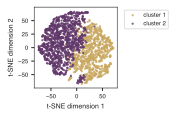

In [30]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

for c in unique:
    print(c)
    sub = all_plot[all_plot["cluster"] == c]
    ax.scatter(sub["f1"], sub["f2"], color=sub["color"].iloc[0], s=5, linewidths=0, alpha=0.8, label="cluster %s" % c)

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")
fig.savefig("Fig6B.pdf", dpi="figure", bbox_inches="tight")

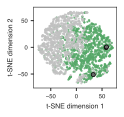

In [31]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

ax.scatter(mrnas["f1"], mrnas["f2"], color=sns.color_palette("deep")[2], edgecolors="darkgreen", linewidths=0,
           s=5, alpha=0.8)
ax.scatter(lncrnas["f1"], lncrnas["f2"], color="silver", edgecolors="dimgray", linewidths=0, s=5, alpha=0.8)
ax.scatter(spec["f1"], spec["f2"], color="dimgray", edgecolors="black", 
           linewidths=0.75, s=17, alpha=1)

ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")

plt.show()
fig.savefig("Fig6C.pdf", dpi="figure", bbox_inches="tight")

In [32]:
titles = ["       max splicing efficiency       ", "       log10 max expression       ", 
          "                GC content                ", 
          "          # TSSs w/in 100bp          ",  "        # enhancers w/in 1Mb        ", 
          "  log10 bp to closest enhancer  ", 
          "       promoter conservation       ", "            exon conservation         ",
          "      log10 DNA locus length       ", "   log10 RNA transcript length   ",
          "       log10 number of exons       "]
logs = [False, True, False, False, False, True, False, False, True, True, True]

fig = plt.subplots(figsize=(6, 6), squeeze=False, sharex=True, sharey=True)

c = 0
for i in range(4):
    for j in range(3):
        ax = plt.subplot2grid((4, 3), (i, j))
        if c < len(sub_feature_cols):
            col = sub_feature_cols[c]
            log = logs[c]

            if log:
                sc = ax.scatter(all_plot["f1"], all_plot["f2"], c=np.log10(all_plot[col]+1), s=2, alpha=0.6,
                                cmap="viridis")
            else:
                sc = ax.scatter(all_plot["f1"], all_plot["f2"], c=all_plot[col], s=2, alpha=0.6, cmap="viridis")
            ax.set_title(titles[c], loc="left",
                         **{"bbox": dict(facecolor='lightgray', edgecolor=None, linewidth=None, 
                                         pad=0.6), "va": "center"})
            
            c += 1
            
            plt.colorbar(sc, ax=ax)
        
        else:
            v = mpl.cm.get_cmap('viridis', 12)
            ax.scatter(mrnas["f1"], mrnas["f2"], color=v(0), s=2, alpha=0.6)
            ax.scatter(lncrnas["f1"], lncrnas["f2"], color=v(11), s=2, alpha=0.6)
            ax.scatter(spec["f1"], spec["f2"], color="white", alpha=1, s=30, 
                        linewidths=1, edgecolors="black")
            ax.set_title("                   biotype                   ", loc="left", color="white",
                         **{"bbox": dict(facecolor='black', edgecolor=None, linewidth=None, 
                                         pad=0.6), "va": "center"})
            plt.colorbar(sc, ax=ax)
        
        if j == 0:
            ax.set_ylabel("t-SNE dimension 2")
        if i == 3:
            ax.set_xlabel("t-SNE dimension 1")

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig("FigS7.pdf", dpi="figure", bbox_inches="tight")

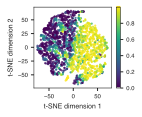

In [33]:
fig, ax = plt.subplots(figsize=(1.75, 1.5), nrows=1, ncols=1)

sc = ax.scatter(all_plot["f1"], all_plot["f2"], c=all_plot["max_eff"], s=5, linewidths=0, alpha=0.8, cmap="viridis")
plt.colorbar(sc, ax=ax)

ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")

plt.show()
#fig.savefig("tsne_splicing_eff.pdf", dpi="figure", bbox_inches="tight")

## 6. limit to genes in screen

In [34]:
hits.head()

gene_id      gene_name              csf cleaner_gene_biotype  \
0  ENSG00000243485.4_2      MIR1302-2  lncRNA_good_csf           intergenic   
1  ENSG00000237613.2_1        FAM138A  lncRNA_good_csf           intergenic   
2  ENSG00000238009.6_2   RP11-34P13.7  lncRNA_good_csf   transcript_overlap   
3  ENSG00000239945.1_2   RP11-34P13.8  lncRNA_good_csf   transcript_overlap   
4  ENSG00000239906.1_1  RP11-34P13.14  lncRNA_good_csf     promoter_overlap   

  minimal_biotype  is_hit   max_eff    max_exp        gc  n_tss  ...  rna_len  \
0          lncRNA  no hit  0.208126   0.559674  0.545147    0.0  ...      712   
1          lncRNA  no hit  0.154032   0.222609  0.465565    0.0  ...     1187   
2          lncRNA  no hit  0.688701   2.415708  0.537288    0.0  ...     2748   
3          lncRNA  no hit  0.027553   2.987223  0.525398    0.0  ...     1319   
4          lncRNA  no hit  0.950739  19.299900  0.461300    0.0  ...      323   

   n_exons  hESC_mean  endo_mean  endo_hESC_abslog2fc  \
0        3   0.088460   0.000000             0.122288   
1        3   0.000000   0.480302             0.565892   
2        4   0.280988   0.111266             0.205054   
3        2   0.207940   0.307150             0.113875   
4        2  13.451185  15.657979             0.205026   

   closest_endo_snp_distance  closest_endo_snp_id  closest_endo_snp_disease  \
0                     863464           rs13303010      pancreatic carcinoma   
1                     858492           rs13303010      pancreatic carcinoma   
2                     760850           rs13303010      pancreatic carcinoma   
3                     803468           rs13303010      pancreatic carcinoma   
4                     754234           rs13303010      pancreatic carcinoma   

   DE_enh_tss_dist  DE_enh_tran_dist  
0           909431            908688  
1           903715            903716  
2           806073            806074  
3           848691            848692  
4           799457            799458  

[5 rows x 26 columns]

In [35]:
hits.is_hit.value_counts()

no hit              7406
stringent no hit     168
hit                   76
Name: is_hit, dtype: int64

In [36]:
print(len(df))
df_screen = df.merge(hits[["gene_id", "is_hit"]], on="gene_id")
print(len(df_screen))
df_screen.head()

33817
7632


f1         f2  index              gene_id      gene_name  \
0  10.923137  64.342995      0  ENSG00000243485.4_2      MIR1302-2   
1  11.089327  64.085808      1  ENSG00000237613.2_1        FAM138A   
2  12.582699  59.820816      3  ENSG00000238009.6_2   RP11-34P13.7   
3  10.371842  64.076843      4  ENSG00000239945.1_2   RP11-34P13.8   
4  12.394470  60.036839      5  ENSG00000239906.1_1  RP11-34P13.14   

               csf cleaner_gene_biotype minimal_biotype  index   max_eff  ...  \
0  lncRNA_good_csf           intergenic          lncRNA      0  0.208126  ...   
1  lncRNA_good_csf           intergenic          lncRNA      1  0.154032  ...   
2  lncRNA_good_csf   transcript_overlap          lncRNA      3  0.688701  ...   
3  lncRNA_good_csf   transcript_overlap          lncRNA      4  0.027553  ...   
4  lncRNA_good_csf     promoter_overlap          lncRNA      5  0.950739  ...   

   n_enh  enh_tss_dist  prom_cons  exon_cons  dna_len  rna_len  n_exons  \
0   18.0        809376       0.00   0.000000     1543      712        3   
1   18.0        803660       0.00   0.006667     1527     1187        3   
2   26.0        706018       0.38   0.505000    36987     2748        4   
3   21.0        748636       0.11   0.140000     1554     1319        2   
4   28.0        699402       0.06   0.270000      549      323        2   

   cluster                                              color  is_hit  
0        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
1        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
2        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
3        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
4        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  

[5 rows x 23 columns]

In [37]:
mrnas_screen = df_screen[df_screen["minimal_biotype"] == "mRNA"]
lncrnas_screen = df_screen[df_screen["minimal_biotype"] != "mRNA"]

mrnas_hits = mrnas_screen[mrnas_screen["is_hit"] == "hit"]
lncrnas_hits = lncrnas_screen[lncrnas_screen["is_hit"] == "hit"]

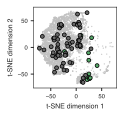

In [38]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

ax.scatter(lncrnas_screen["f1"], lncrnas_screen["f2"], color="silver", s=2, linewidths=0, alpha=0.8)
ax.scatter(mrnas_hits["f1"], mrnas_hits["f2"], color=sns.color_palette("deep")[2], edgecolors="black", s=15, alpha=1)
ax.scatter(lncrnas_hits["f1"], lncrnas_hits["f2"], color="dimgray", edgecolors="black", s=15, alpha=1)

ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")

plt.show()

2
1


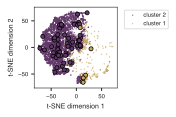

In [39]:
fig, ax = plt.subplots(figsize=(1.5, 1.5), nrows=1, ncols=1)

for c in unique[::-1]:
    print(c)
    sub = lncrnas_screen[lncrnas_screen["cluster"] == c]
    ax.scatter(sub["f1"], sub["f2"], color=sub["color"].iloc[0], s=2, linewidths=0, 
               alpha=0.7, label="cluster %s" % c)
    
    sub = lncrnas_hits[lncrnas_hits["cluster"] == c]
    ax.scatter(sub["f1"], sub["f2"], color=sub["color"].iloc[0], edgecolors="black", 
               linewidths=0.75, s=17, alpha=1, zorder=100)

plt.legend(loc=2, bbox_to_anchor=(1.05, 1))

ax.set_xlabel("t-SNE dimension 1")
ax.set_ylabel("t-SNE dimension 2")

plt.show()
fig.savefig("Fig6D.pdf", dpi="figure", bbox_inches="tight")

In [40]:
dedup = lncrnas_hits[["f1", "f2", "minimal_biotype", "cleaner_gene_biotype", "gene_name", "cluster"]].drop_duplicates()
print(len(dedup))
dedup.sort_values(by="f1", ascending=False).head(10)

65


f1         f2 minimal_biotype cleaner_gene_biotype     gene_name  \
4976  29.052170  -2.616636          lncRNA   transcript_overlap          MEG3   
3303  21.357393  65.047401          lncRNA           intergenic         GLIDR   
328   18.368746 -52.304790          lncRNA   transcript_overlap   LAMTOR5-AS1   
4330  13.682017 -57.304211          lncRNA   transcript_overlap      HOXC-AS1   
7582  13.436091 -65.588028          lncRNA   transcript_overlap     LINC00623   
242   11.527550 -64.283348          lncRNA   transcript_overlap     FOXD3-AS1   
1634   8.574821  18.241850          lncRNA           intergenic         DANCR   
5793   8.293935   1.140768          lncRNA     promoter_overlap    PITPNA-AS1   
7048   7.620339   4.731588          lncRNA           intergenic  RP1-148H17.1   
7357   7.570561   3.569239          lncRNA     promoter_overlap  RP3-508I15.9   

      cluster  
4976        1  
3303        2  
328         1  
4330        1  
7582        1  
242         1  
1634        2  
5793        2  
7048        2  
7357        2

In [41]:
tmp = dedup[dedup["cluster"] == 1]
tmp.sort_values(by="f1")

f1         f2 minimal_biotype cleaner_gene_biotype    gene_name  \
3241   7.452582  37.080124          lncRNA   transcript_overlap    VLDLR-AS1   
242   11.527550 -64.283348          lncRNA   transcript_overlap    FOXD3-AS1   
7582  13.436091 -65.588028          lncRNA   transcript_overlap    LINC00623   
4330  13.682017 -57.304211          lncRNA   transcript_overlap     HOXC-AS1   
328   18.368746 -52.304790          lncRNA   transcript_overlap  LAMTOR5-AS1   
4976  29.052170  -2.616636          lncRNA   transcript_overlap         MEG3   

      cluster  
3241        1  
242         1  
7582        1  
4330        1  
328         1  
4976        1

## 9. write files

In [42]:
len(df)

33817

In [43]:
df.minimal_biotype.value_counts()

mRNA      20122
lncRNA    13695
Name: minimal_biotype, dtype: int64

In [44]:
sub_cols = ["gene_id", "gene_name", "minimal_biotype", "max_eff", "max_exp", "gc", "n_tss", "n_enh", "enh_tss_dist",
            "prom_cons", "exon_cons", "dna_len", "rna_len", "n_exons", "f1", "f2", "cluster"]
supp = df[sub_cols]
supp.columns = ["gene_id", "gene_name", "biotype", "max_splicing_eff", "max_expression", "gc", "n_tss", "n_enh",
                "closest_enh_dist", "tss_conservation", "exon_conservation", "dna_locus_len", "rna_trans_len",
                "n_exons", "tsne_f1", "tsne_f2", "assigned_cluster"]

In [45]:
supp = supp.sort_values(by="gene_id")
supp.head()

gene_id gene_name biotype  max_splicing_eff  \
33816                 DIGIT     DIGIT  lncRNA          0.224504   
32608  ENSG00000000003.14_1    TSPAN6    mRNA          0.977842   
32607   ENSG00000000005.5_1      TNMD    mRNA          0.670927   
30615  ENSG00000000419.12_1      DPM1    mRNA          0.991128   
2243   ENSG00000000457.13_1     SCYL3    mRNA          0.847358   

       max_expression        gc  n_tss  n_enh  closest_enh_dist  \
33816        0.639554  0.480683    0.0   72.0              2518   
32608       89.219127  0.566943    7.0   16.0              5263   
32607        2.058903  0.586794    1.0   15.0             51631   
30615      273.514690  0.604317    3.0  171.0               588   
2243        11.621038  0.554634    1.0   34.0              2279   

       tss_conservation  exon_conservation  dna_locus_len  rna_trans_len  \
33816              0.10           0.000000           2966           2226   
32608              0.04           0.940000           9995           3796   
32607              1.00           1.000000          15083           1339   
30615              0.00           0.966667          23688           1161   
2243               0.00           0.910000          44321           6364   

       n_exons    tsne_f1    tsne_f2  assigned_cluster  
33816        2 -45.172131  -9.846272                 2  
32608        8  44.955196   9.168408                 1  
32607        7  42.289146 -54.429031                 1  
30615       10  15.815658 -39.113323                 1  
2243        14  35.952137  42.544262                 1

In [46]:
supp.to_csv("../../../data/04__clusters/SuppTable_S7.cluster_predictions.txt", sep="\t", index=False)

In [47]:
df_screen.head()

f1         f2  index              gene_id      gene_name  \
0  10.923137  64.342995      0  ENSG00000243485.4_2      MIR1302-2   
1  11.089327  64.085808      1  ENSG00000237613.2_1        FAM138A   
2  12.582699  59.820816      3  ENSG00000238009.6_2   RP11-34P13.7   
3  10.371842  64.076843      4  ENSG00000239945.1_2   RP11-34P13.8   
4  12.394470  60.036839      5  ENSG00000239906.1_1  RP11-34P13.14   

               csf cleaner_gene_biotype minimal_biotype  index   max_eff  ...  \
0  lncRNA_good_csf           intergenic          lncRNA      0  0.208126  ...   
1  lncRNA_good_csf           intergenic          lncRNA      1  0.154032  ...   
2  lncRNA_good_csf   transcript_overlap          lncRNA      3  0.688701  ...   
3  lncRNA_good_csf   transcript_overlap          lncRNA      4  0.027553  ...   
4  lncRNA_good_csf     promoter_overlap          lncRNA      5  0.950739  ...   

   n_enh  enh_tss_dist  prom_cons  exon_cons  dna_len  rna_len  n_exons  \
0   18.0        809376       0.00   0.000000     1543      712        3   
1   18.0        803660       0.00   0.006667     1527     1187        3   
2   26.0        706018       0.38   0.505000    36987     2748        4   
3   21.0        748636       0.11   0.140000     1554     1319        2   
4   28.0        699402       0.06   0.270000      549      323        2   

   cluster                                              color  is_hit  
0        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
1        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
2        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
3        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  
4        2  (0.37998775, 0.21876825000000005, 0.4108567500...  no hit  

[5 rows x 23 columns]

In [48]:
sub_cols = ["gene_id", "gene_name", "minimal_biotype", "cleaner_gene_biotype", "f1", "f2", "is_hit", "cluster"]
supp = df_screen[sub_cols]
supp.columns = ["gene_id", "gene_name", "biotype", "lncrna_class", "tsne_f1", "tsne_f2", "screen_hit", 
                "assigned_cluster"]

In [49]:
supp[supp["gene_name"].isin(["RP11-1144P22.1", "CTD-2058B24.2", "DANCR", "DIGIT", "RP11-222K16.2",
                             "FOXD3-AS1", "RP11-479O16.1", "RP11-120D5.1"])]

gene_id       gene_name biotype        lncrna_class  \
242   ENSG00000230798.5_1       FOXD3-AS1  lncRNA  transcript_overlap   
1213  ENSG00000272282.1_1   RP11-222K16.2  lncRNA          intergenic   
1634  ENSG00000226950.6_1           DANCR  lncRNA          intergenic   
1976  ENSG00000248475.5_1   RP11-479O16.1  lncRNA  transcript_overlap   
3051  ENSG00000254277.1_1  RP11-1144P22.1  lncRNA          intergenic   
4805  ENSG00000259048.1_1   CTD-2058B24.2  lncRNA  transcript_overlap   
7421  ENSG00000234129.7_1    RP11-120D5.1  lncRNA    promoter_overlap   
7631                DIGIT           DIGIT  lncRNA    promoter_overlap   

        tsne_f1    tsne_f2 screen_hit  assigned_cluster  
242   11.527550 -64.283348        hit                 1  
1213 -15.430798  17.161217        hit                 2  
1634   8.574821  18.241850        hit                 2  
1976 -63.328957  -4.636231        hit                 2  
3051   7.272441  22.807289        hit                 2  
4805  -4.441723  43.540226        hit                 2  
7421   6.294654  43.613403        hit                 2  
7631 -45.172131  -9.846272        hit                 2